In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [3]:
using SciMLSensitivity

In [4]:
solver_args = Dict(:adaptive => false, 
                    :dt => 0.01,
                    :sensealg => InterpolatingAdjoint(; autojacvec=ZygoteVJP()),
                    :save_start => true)

Dict{Symbol, Any} with 4 entries:
  :adaptive   => false
  :sensealg   => InterpolatingAdjoint{0, true, Val{:central}, ZygoteVJP}(Zygote…
  :dt         => 0.01
  :save_start => true

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args,
                    leakage=-0.1)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [7]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [8]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp (generic function with 1 method)

In [9]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [10]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [11]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

(Float32[0.43635908 -0.02072694 … -0.014802111 -0.0019893101; -0.17784306 0.30380124 … -0.07276908 -0.0056274263], Bool[0 0 … 1 1; 1 1 … 0 0])

# Test FP32

In [12]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), 
                x -> tanh_fast.(x), 
                x -> x, 
                PhasorDense(2 => 128), 
                x -> x,
                PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

build_mlp (generic function with 1 method)

In [13]:
model, ps, st = build_mlp(args)

(Chain{@NamedTuple{layer_1::LayerNorm{Tuple{Int64}, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon, Static.True}, layer_2::WrappedFunction{var"#40#43"}, layer_3::WrappedFunction{var"#41#44"}, layer_4::PhasorDense, layer_5::WrappedFunction{var"#42#45"}, layer_6::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction(#40), layer_3 = WrappedFunction(#41), layer_4 = PhasorDense((2, 128)), layer_5 = WrappedFunction(#42), layer_6 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.025199654 0.005086061; 0.021546587 -0.11127125; … ; 0.15865159 -0.030458387; -0.24032864 0.049523916], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 

In [14]:
function build_ode_mlp(args, spk_args)
    ode_model = Chain(LayerNorm((2,)),
                x -> tanh_fast.(x),
                x -> phase_to_current(x, spk_args=spk_args, tspan=(0.0, 10.0)),
                PhasorDense(2 => 128, return_solution=true),
                x -> mean_phase(x, 1, spk_args=spk_args, offset=0.0),
                PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, ode_model)
    return ode_model, ps, st
end

build_ode_mlp (generic function with 1 method)

In [15]:
ode_model, ps_ode, st_ode = build_ode_mlp(args, spk_args)

(Chain{@NamedTuple{layer_1::LayerNorm{Tuple{Int64}, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon, Static.True}, layer_2::WrappedFunction{var"#46#49"}, layer_3::WrappedFunction{var"#47#50"{SpikingArgs}}, layer_4::PhasorDense, layer_5::WrappedFunction{var"#48#51"{SpikingArgs}}, layer_6::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction(#46), layer_3 = WrappedFunction(#47), layer_4 = PhasorDense((2, 128)), layer_5 = WrappedFunction(#48), layer_6 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.27116936 0.0861502; -0.07204794 -0.15312071; … ; -0.039547402 -0.030699156; 0.003936669 -0.020530548], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [16]:
ode_model(x, ps_ode, st_ode)

([-0.6529425219011482 0.73261814686954 … -0.6005193146071944 -0.7923303905716167; -0.9850556509699054 -0.9900013768289555 … -0.9727555523687974 -0.9898457073281414], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [17]:
y_f, _ = model(x, ps, st)

(Float32[-0.020149678 0.045700032 … 0.014530523 0.011981524; -0.022495363 -0.009955378 … -0.054838568 -0.0231262], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [18]:
ps |> keys

(:layer_1, :layer_2, :layer_3, :layer_4, :layer_5, :layer_6)

In [19]:
y_ode, _ = ode_model(x, ps, st)

([-0.018581441236175507 0.047138473236726056 … 0.013608260875093233 0.01210262652855847; -0.025152671585789974 -0.011296737019864979 … -0.057036539426011 -0.023492269066139607], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

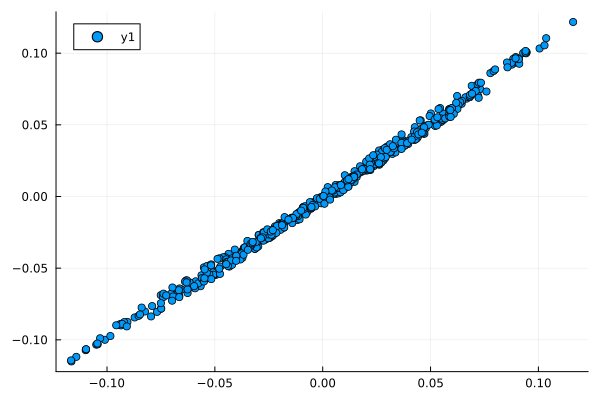

In [20]:
scatter(vec(y_f), vec(y_ode))

In [21]:
cor_realvals(vec(y_f), vec(y_ode))

0.9979983261321126

In [22]:
y_ode

2×256 Matrix{Float64}:
 -0.0185814   0.0471385  -0.0685738    0.0170441  …   0.0136083   0.0121026
 -0.0251527  -0.0112967  -0.00751239  -0.0257743     -0.0570365  -0.0234923

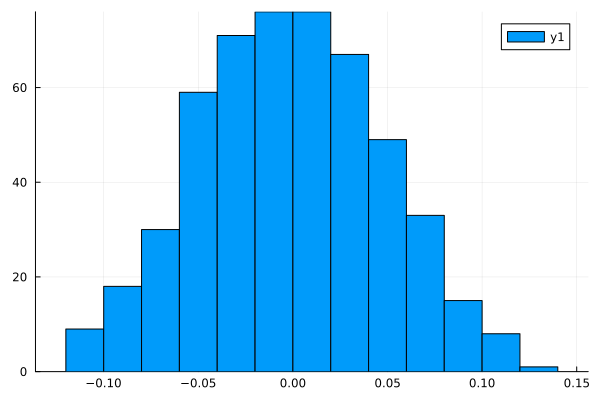

In [23]:
histogram(vec(y_ode))

In [24]:
mean(abs.(y_ode))

0.039451078794762166

In [25]:
psf = ComponentArray(ps_ode)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.27116936 0.0861502; -0.07204794 -0.15312071; … ; -0.039547402 -0.030699156; 0.003936669 -0.020530548], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = Float32[], layer_6 = (weight = Float32[0.022885242 -0.20376815 … 0.006069808 0.04844268; 0.22680388 0.0039727697 … -0.09966416 -0.19447207], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [26]:
val_ode, grads_ode = withgradient(p -> mean(quadrature_loss(ode_model(x, p, st_ode)[1], y)), psf)

(val = 1.4716633546791829, grad = ((layer_1 = (bias = ComplexF64[0.0 + 0.0im; 0.0 + 0.0im;;], scale = ComplexF64[0.0 + 0.0im; 0.0 + 0.0im;;]), layer_2 = ComplexF64[], layer_3 = ComplexF64[], layer_4 = (weight = ComplexF64[0.009551892057061195 + 0.0im -0.0030682203359901905 + 0.0im; -0.0892847329378128 + 0.0im 0.012274425476789474 + 0.0im; … ; 0.002540412824600935 + 0.0im -0.0001462370273657143 + 0.0im; 0.017965639010071754 + 0.0im -0.005354567430913448 + 0.0im], bias_real = ComplexF64[-0.0024249397683888674 + 0.0im, -0.004517123568803072 + 0.0im, 0.027120357379317284 + 0.0im, 0.0007290230714716017 + 0.0im, 0.005727333948016167 + 0.0im, -0.0006514873821288347 + 0.0im, 0.00829428993165493 + 0.0im, -0.00789313018321991 + 0.0im, -0.0001338126603513956 + 0.0im, -0.004801392555236816 + 0.0im  …  0.00019703990255948156 + 0.0im, 0.00038832545396871865 + 0.0im, -0.007311934605240822 + 0.0im, 0.004099258687347174 + 0.0im, -0.0006642324733547866 + 0.0im, 0.0006615458405576646 + 0.0im, -0.00983987

In [33]:
grads_ode[1].layer_4.weight

128×2 reshape(view(::Vector{ComplexF64}, 5:260), 128, 2) with eltype ComplexF64:
  0.00955189+0.0im   -0.00306822+0.0im
  -0.0892847+0.0im     0.0122744+0.0im
   0.0954659+0.0im    -0.0133291+0.0im
  0.00395883+0.0im   -0.00115883+0.0im
   -0.060891+0.0im     0.0165508+0.0im
 -0.00786388+0.0im    0.00401078+0.0im
   0.0634439+0.0im   -0.00928477+0.0im
  -0.0445711+0.0im     0.0197011+0.0im
  -0.0235011+0.0im    0.00613452+0.0im
   0.0327268+0.0im    -0.0119944+0.0im
   -0.106791+0.0im     0.0221547+0.0im
    0.047185+0.0im    -0.0126176+0.0im
  -0.0446541+0.0im     0.0230778+0.0im
            ⋮       
   0.0377213+0.0im    -0.0115442+0.0im
   0.0113842+0.0im   -0.00379972+0.0im
  0.00503375+0.0im   -0.00175974+0.0im
   0.0113007+0.0im   -0.00508075+0.0im
  -0.0591806+0.0im   0.000963235+0.0im
  -0.0300678+0.0im    0.00834283+0.0im
   -0.017228+0.0im    0.00129937+0.0im
  -0.0172971+0.0im    0.00578342+0.0im
  -0.0561604+0.0im    0.00563607+0.0im
  0.00656007+0.0im    0.00061724+0.0im
 

In [27]:
val, grads = withgradient(p -> mean(quadrature_loss(model(x, p, st_ode)[1], y)), psf)

(val = 1.4706037321336183, grad = ((layer_1 = (bias = ComplexF32[0.11004538f0 + 0.0f0im; -0.7869317f0 + 0.0f0im;;], scale = ComplexF32[-0.0014921434f0 + 0.0f0im; 0.08974712f0 + 0.0f0im;;]), layer_2 = ComplexF32[], layer_3 = ComplexF32[], layer_4 = (weight = ComplexF32[0.005294011f0 + 0.0211437f0im -0.0061101327f0 + 0.023479044f0im; -0.087118864f0 + 0.18229263f0im 0.012018243f0 + 0.1995743f0im; … ; 0.0030810372f0 - 0.016129162f0im 0.0005020734f0 - 0.019077197f0im; 0.018876668f0 - 0.05854056f0im -0.0037935008f0 - 0.06586892f0im], bias_real = ComplexF32[-0.00090918416f0 + 0.0f0im, -0.004436491f0 + 0.0f0im, 0.026448578f0 + 0.0f0im, 0.00066049903f0 + 0.0f0im, 0.0056137154f0 + 0.0f0im, -0.00051884924f0 + 0.0f0im, 0.008129289f0 + 0.0f0im, -0.0077941944f0 + 0.0f0im, 4.590717f-5 + 0.0f0im, -0.0047031986f0 + 0.0f0im  …  0.00019024023f0 + 0.0f0im, 0.0010075943f0 + 0.0f0im, -0.0071846233f0 + 0.0f0im, 0.0040901564f0 + 0.0f0im, -0.00064924866f0 + 0.0f0im, 0.00063804205f0 + 0.0f0im, -0.009481003f0 + 

In [36]:
typeof(psf)

ComponentVector{Float32, Vector{Float32}, Tuple{Axis{(layer_1 = ViewAxis(1:4, Axis(bias = ViewAxis(1:2, ShapedAxis((2, 1))), scale = ViewAxis(3:4, ShapedAxis((2, 1))))), layer_2 = ViewAxis(5:4, Shaped1DAxis((0,))), layer_3 = ViewAxis(5:4, Shaped1DAxis((0,))), layer_4 = ViewAxis(5:516, Axis(weight = ViewAxis(1:256, ShapedAxis((128, 2))), bias_real = ViewAxis(257:384, Shaped1DAxis((128,))), bias_imag = ViewAxis(385:512, Shaped1DAxis((128,))))), layer_5 = ViewAxis(517:516, Shaped1DAxis((0,))), layer_6 = ViewAxis(517:776, Axis(weight = ViewAxis(1:256, ShapedAxis((2, 128))), bias_real = ViewAxis(257:258, Shaped1DAxis((2,))), bias_imag = ViewAxis(259:260, Shaped1DAxis((2,))))))}}} (alias for ComponentArray{Float32, 1, Array{Float32, 1}, Tuple{Axis{(layer_1 = ViewAxis(1:4, Axis(bias = ViewAxis(1:2, ShapedAxis((2, 1))), scale = ViewAxis(3:4, ShapedAxis((2, 1))))), layer_2 = ViewAxis(5:4, Shaped1DAxis((0,))), layer_3 = ViewAxis(5:4, Shaped1DAxis((0,))), layer_4 = ViewAxis(5:516, Axis(weight = V

In [34]:
grads[1].layer_4.weight

128×2 reshape(view(::Vector{ComplexF32}, 5:260), 128, 2) with eltype ComplexF32:
  0.00529401+0.0211437im    -0.00611013+0.023479im
  -0.0871189+0.182293im       0.0120182+0.199574im
   0.0928833-0.175956im      -0.0150468-0.183992im
  0.00442509-0.0173219im   -0.000370483-0.0211815im
  -0.0595796+0.122791im       0.0161638+0.132408im
 -0.00800801+0.0186389im     0.00338485+0.0204621im
   0.0620321-0.131069im      -0.0090753-0.143393im
  -0.0426547+0.070088im       0.0203754+0.0690743im
  -0.0218278+0.0259176im     0.00703433+0.0256562im
   0.0331975-0.0833844im      -0.010634-0.0899778im
   -0.103979+0.21144im        0.0219164+0.229197im
   0.0451312-0.0775983im     -0.0131873-0.0820299im
  -0.0444169+0.0859131im       0.020272+0.0899815im
            ⋮              
   0.0378376-0.0926379im      -0.010083-0.102879im
   0.0115811-0.0304611im    -0.00317585-0.0338214im
  0.00483692-0.00860635im   -0.00179697-0.00899106im
  0.00827443+0.0162869im    -0.00813626+0.0249653im
   -0.057815+

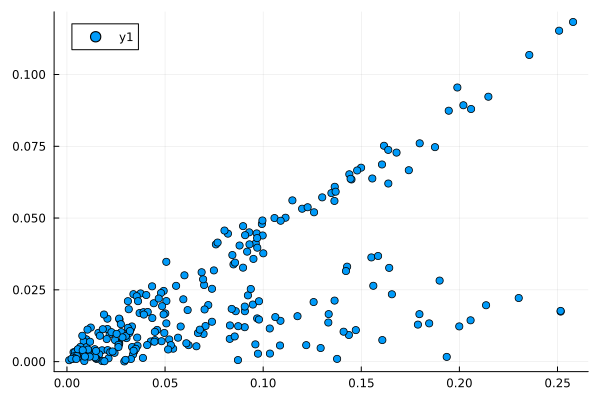

In [41]:
scatter(vec(abs.(grads[1].layer_4.weight)), vec(abs.(grads_ode[1].layer_4.weight)))

In [30]:
cor_realvals(vec(grads[1].layer_4.weight), vec(grads_ode[1].layer_4.weight))

0.9973616f0

In [ ]:
ode_correlation(model, ode_model, psf, st, x, y)

[ Info: Running ODE correlation test...


(true, true, true)

In [31]:
losses, ps_train, st_train = train(model, ps, st, train_loader, args)

[ Info: Training on CPU


(Any[1.470610285835948, 1.2797578581432816, 1.2667509824545118, 1.1044226741976566, 1.0937309365409635, 1.070293620060026, 1.1034585878486642, 1.1315326869613376, 1.0096109471075247, 1.081606272780796  …  0.10250371031574979, 0.06884748192157294, 0.06350119359570362, 0.07024072672082649, 0.08902531930604576, 0.07827954976032266, 0.08402883979838839, 0.08358139183162153, 0.09079564953722642, 0.07497625157008622], (layer_1 = (bias = Float32[-0.19127946; -0.012986892;;], scale = Float32[0.8404681; 0.9021617;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.3027374 0.07465308; -0.09378023 -0.13670401; … ; -0.020455208 -0.012457536; 0.029322494 0.003102203], bias_real = Float32[0.9619752, 1.0007766, 1.0180982, 1.0119642, 1.0205826, 0.9423916, 0.97089803, 0.9752761, 1.0076125, 1.008484  …  1.0029157, 1.0008974, 1.0031078, 1.0313046, 1.0126935, 1.0050039, 0.9916778, 0.9582613, 1.0252, 0.9983308], bias_imag = Float32[0.07851386, -0.028444134, -0.007862561, -0.0

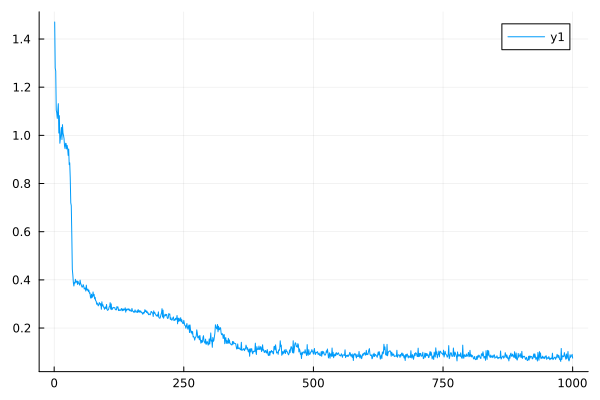

In [32]:
plot(losses)

In [33]:
losses[end]

0.07497625157008622

In [34]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.07724078951642868, 0.952734375)

In [35]:
psf = ComponentArray(ps)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.27116936 0.0861502; -0.07204794 -0.15312071; … ; -0.039547402 -0.030699156; 0.003936669 -0.020530548], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = Float32[], layer_6 = (weight = Float32[0.022885242 -0.20376815 … 0.006069808 0.04844268; 0.22680388 0.0039727697 … -0.09966416 -0.19447207], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [36]:
losses_ode, ps_train_ode, st_train_ode = train(ode_model, psf, st, train_loader, args, verbose = true)

[ Info: Training on CPU


Epoch 1 loss: 1.471670614760603
Epoch 1 loss: 1.2797755869866716
Epoch 1 loss: 1.267028676294693
Epoch 1 loss: 1.104271345598783
Epoch 1 loss: 1.0964540977271757
Epoch 1 loss: 1.074113602965645
Epoch 1 loss: 1.108689217230584
Epoch 1 loss: 1.1376543798198642
Epoch 1 loss: 1.0144064490196423
Epoch 1 loss: 1.0880532231313498
Epoch 1 loss: 0.9719947171674937
Epoch 1 loss: 0.9929546981781718
Epoch 1 loss: 1.0112800536023048
Epoch 1 loss: 1.0392624209832433
Epoch 1 loss: 0.9886868709969514
Epoch 1 loss: 1.0512093379505238


LoadError: InterruptException:

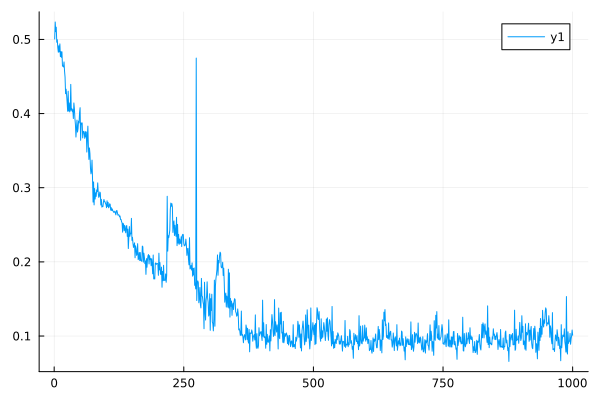

In [ ]:
plot(losses_ode)

In [ ]:
loss_and_accuracy(test_loader, ode_model, ps_train_ode, st_train_ode)

(0.1108247329922166, 0.96640625)